In [1]:
##from https://github.com/eriklindernoren/Keras-GAN/blob/master/infogan/infogan.py


from __future__ import print_function, division

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, Lambda
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow.python.keras.backend as K

import matplotlib.pyplot as plt

import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Geometry import Point3D

from tqdm import tqdm_notebook

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

import numpy as np

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline



from xyz2mol import *

In [2]:
mols = list()
smiles = [i.strip('\n') for i in open('small_dataset.smi', 'r').readlines()]
for smi in tqdm_notebook(smiles):
    mols.append(Chem.MolFromSmiles(smi))

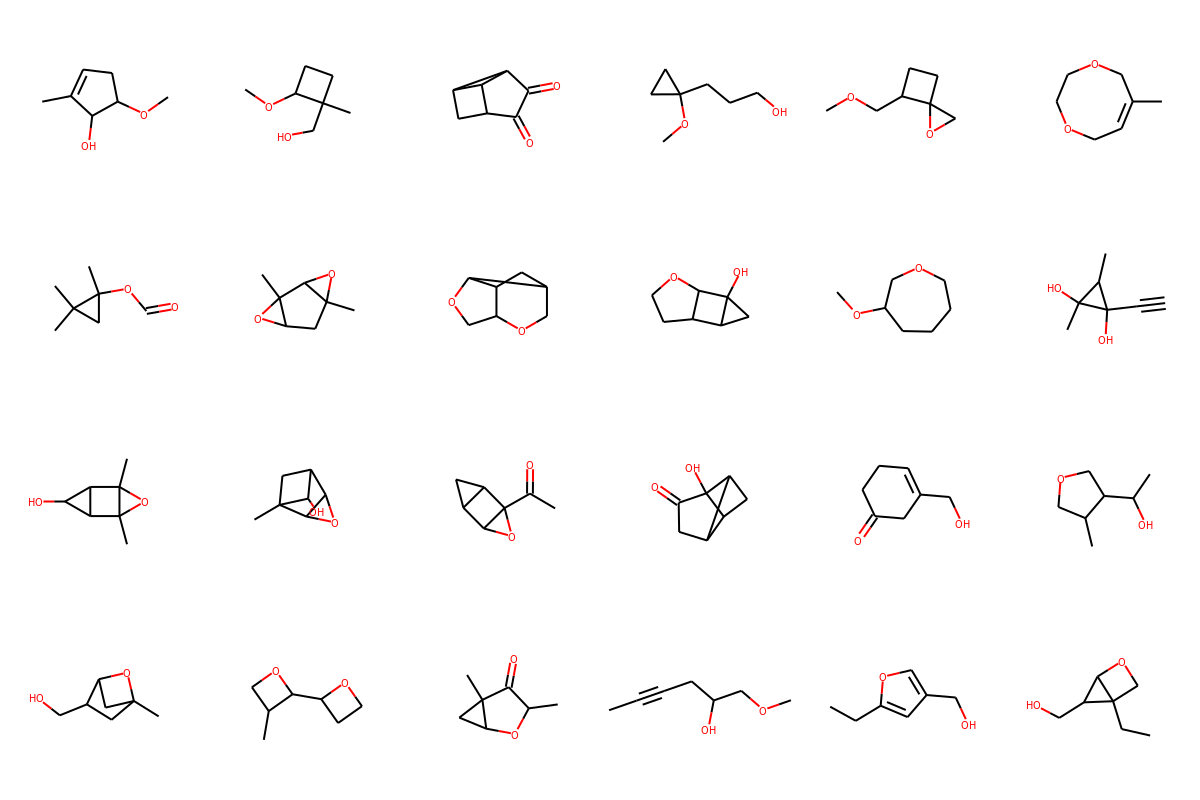

In [3]:
Draw.MolsToGridImage(mols[:24], molsPerRow=6)


In [4]:

def getEDM(mol):
    #get 3d coords
    m3 = Chem.AddHs(mol)
    embed = AllChem.EmbedMolecule(m3)
    if embed+1:  
        m3 = Chem.RemoveHs(m3)
        conformer = m3.GetConformer(0)
        positions = conformer.GetPositions()
        return positions
    else:
        return None
    
def permute_edm(edm, atom_identities, num_permutes=1000):
    edm= squareform(edm)
    idx = np.arange(9)
    edm_list = list()
    atom_list = list()
    
    for _ in range(num_permutes):
        np.random.shuffle(idx)
        edm_copy = edm[idx][:,idx]
        edm_list.append(squareform(edm_copy))
        atom_list.append(atom_identities[idx])
    return edm_list, atom_list

In [5]:
edms = list()
atomidx = list()
for m in tqdm_notebook(mols[:100]):
    points = getEDM(m)
    if points is None:
        None
    else:
        edm = pdist(points)
        atoms = np.clip(np.array([i.GetAtomicNum() for i in m.GetAtoms()])-7, 0,1)
        el, al = permute_edm(edm, atoms)
        for e, a in zip(el, al):
            edms.append(e)
            atomidx.append(a)

In [6]:
edms = np.array(edms)
data = copy.copy(edms)
##reduce noise using pca?
#pca = PCA(0.99, whiten=True) ##keep 99 percent of variance. 
#data = pca.fit_transform(edms)

#scale to maximum 1:
#maximum = np.max(data)
#print('max is:', maximum)
#data = data/maximum


#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#data = scaler.fit_transform(edms)
#maximum = np.max(np.abs(data))
#print('max is:', maximum)
#data = data/maximum

data = np.log10(edms)
#data_mean = np.mean(data)
#data = data- np.mean(data)
maximum = np.max(np.abs(data))
print('max is:', maximum)
print('min is:', np.min(data))

#print('Went from:', edms.shape, 'dimensions to:', data.shape)


##Stacking EDMs onto atom identities:

data = np.hstack([data, np.array(atomidx)])

max is: 0.851430298659673
min is: 0.07686159609205322


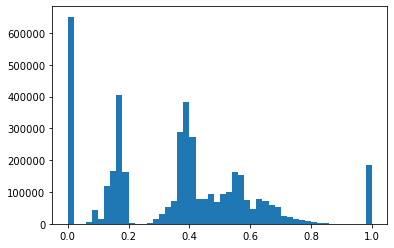

In [7]:
_ = plt.hist(data[:,:].flatten(), bins=50)

# Simple GAN
    

In [10]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop
##https://skymind.ai/wiki/generative-adversarial-network-gan

scores = list()

class GAN():
    def __init__(self):
        self.img_cols = 45
        self.channels = 1
        self.img_shape = (self.img_cols, self.channels)
        print(self.img_shape)

        optimizer = Adam(0.0002, 0.5)
        #optimizer = RMSprop()

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)

        # The generator takes noise as input and generated imgs
        z = Input(shape=(100,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        noise_shape = (100,)

        model = Sequential()

        model.add(Dense(256, input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        img_shape = (self.img_cols, self.channels)
        model = Sequential()

        model.add(Flatten(input_shape=img_shape))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.3))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.3))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.3))
        #model.add(BatchNormalization(momentum=0.8))


        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=img_shape)
        validity = model(img)

        return Model(img, validity)

    
    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("gan/images/mnist_%d.png" % epoch)
        plt.close()    

    def train(self, epochs, batch_size=128, save_interval=50):

        ## Load the dataset
        #(X_train, _), (_, _) = mnist.load_data()
        X_train = data

        # Rescale -1 to 1
#        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=2)

        half_batch = int(batch_size / 2)

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            #X= np.concatenate([imgs, gen_imgs])
            #y_dis=np.zeros(batch_size)
            #y_dis[:half_batch]=0.9
            #self.discriminator.trainable=True
            #d_loss = self.discriminator.train_on_batch(X, y_dis)
            


            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 100))

            #y_gen = np.ones(batch_size)

            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = np.array([1] * batch_size)

            #added:
            #self.discriminator.trainable=False
            
            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y)
            #g_loss = 0
            # Plot the progress
            if epoch%10==0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            scores.append([epoch, d_loss[0], d_loss[1], g_loss])
            ## If at save interval => save generated image samples
            #if epoch % save_interval == 0:
            #    self.save_imgs(epoch)


In [ ]:
gan = GAN()
gan.train(epochs=30000, batch_size=4, save_interval=200)


(45, 1)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 45)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              47104     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)      

820 [D loss: 0.016689, acc.: 100.00%] [G loss: 9.035364]
830 [D loss: 0.027894, acc.: 100.00%] [G loss: 6.069570]
840 [D loss: 0.616720, acc.: 75.00%] [G loss: 5.989343]
850 [D loss: 0.052539, acc.: 100.00%] [G loss: 6.707808]
860 [D loss: 0.020539, acc.: 100.00%] [G loss: 11.222298]
870 [D loss: 0.004529, acc.: 100.00%] [G loss: 9.007511]
880 [D loss: 0.943829, acc.: 75.00%] [G loss: 12.239346]
890 [D loss: 0.082731, acc.: 100.00%] [G loss: 9.968653]
900 [D loss: 0.038708, acc.: 100.00%] [G loss: 6.700693]
910 [D loss: 0.004309, acc.: 100.00%] [G loss: 9.092363]
920 [D loss: 0.013512, acc.: 100.00%] [G loss: 5.868910]
930 [D loss: 0.165499, acc.: 100.00%] [G loss: 11.888651]
940 [D loss: 0.038306, acc.: 100.00%] [G loss: 11.365084]
950 [D loss: 0.023517, acc.: 100.00%] [G loss: 8.076108]
960 [D loss: 0.273928, acc.: 75.00%] [G loss: 9.626522]
970 [D loss: 0.112043, acc.: 100.00%] [G loss: 9.657290]
980 [D loss: 0.025936, acc.: 100.00%] [G loss: 9.022558]
990 [D loss: 0.002847, acc.: 1

2240 [D loss: 0.021700, acc.: 100.00%] [G loss: 6.108720]
2250 [D loss: 0.034519, acc.: 100.00%] [G loss: 4.749907]
2260 [D loss: 0.075382, acc.: 100.00%] [G loss: 6.553410]
2270 [D loss: 0.011107, acc.: 100.00%] [G loss: 4.662624]
2280 [D loss: 0.018763, acc.: 100.00%] [G loss: 8.163058]
2290 [D loss: 0.109611, acc.: 100.00%] [G loss: 7.274776]
2300 [D loss: 0.022853, acc.: 100.00%] [G loss: 7.819430]
2310 [D loss: 0.848985, acc.: 75.00%] [G loss: 6.014304]
2320 [D loss: 0.051281, acc.: 100.00%] [G loss: 6.038012]
2330 [D loss: 0.248416, acc.: 75.00%] [G loss: 6.019395]
2340 [D loss: 0.301860, acc.: 75.00%] [G loss: 7.371786]
2350 [D loss: 0.627947, acc.: 75.00%] [G loss: 7.048051]
2360 [D loss: 0.055465, acc.: 100.00%] [G loss: 7.845475]
2370 [D loss: 0.015759, acc.: 100.00%] [G loss: 6.330004]
2380 [D loss: 0.029505, acc.: 100.00%] [G loss: 12.018096]
2390 [D loss: 0.039883, acc.: 100.00%] [G loss: 4.872890]
2400 [D loss: 0.319946, acc.: 75.00%] [G loss: 3.137463]
2410 [D loss: 0.53

3680 [D loss: 0.914866, acc.: 50.00%] [G loss: 2.319426]
3690 [D loss: 0.839652, acc.: 50.00%] [G loss: 1.084726]
3700 [D loss: 0.304377, acc.: 100.00%] [G loss: 1.645195]
3710 [D loss: 0.682623, acc.: 75.00%] [G loss: 2.669773]
3720 [D loss: 0.358890, acc.: 100.00%] [G loss: 2.808139]
3730 [D loss: 0.512612, acc.: 75.00%] [G loss: 1.513858]
3740 [D loss: 0.160505, acc.: 100.00%] [G loss: 3.152537]
3750 [D loss: 0.133280, acc.: 100.00%] [G loss: 2.552184]
3760 [D loss: 0.575941, acc.: 75.00%] [G loss: 4.851497]
3770 [D loss: 0.113344, acc.: 100.00%] [G loss: 3.639212]
3780 [D loss: 0.360792, acc.: 75.00%] [G loss: 2.785022]
3790 [D loss: 0.986186, acc.: 50.00%] [G loss: 2.320687]
3800 [D loss: 0.912284, acc.: 50.00%] [G loss: 2.644414]
3810 [D loss: 0.342251, acc.: 100.00%] [G loss: 2.146745]
3820 [D loss: 0.483329, acc.: 50.00%] [G loss: 1.782607]
3830 [D loss: 0.689141, acc.: 50.00%] [G loss: 2.838971]
3840 [D loss: 0.358554, acc.: 100.00%] [G loss: 1.467408]
3850 [D loss: 0.225236, 

5120 [D loss: 0.462054, acc.: 75.00%] [G loss: 2.350137]
5130 [D loss: 0.463866, acc.: 100.00%] [G loss: 1.567446]
5140 [D loss: 0.873153, acc.: 50.00%] [G loss: 1.916132]
5150 [D loss: 0.581289, acc.: 50.00%] [G loss: 1.568970]
5160 [D loss: 0.229490, acc.: 100.00%] [G loss: 1.820595]
5170 [D loss: 0.378155, acc.: 100.00%] [G loss: 2.574621]
5180 [D loss: 0.375634, acc.: 100.00%] [G loss: 2.444761]
5190 [D loss: 0.671466, acc.: 50.00%] [G loss: 1.834509]
5200 [D loss: 0.355029, acc.: 100.00%] [G loss: 2.052114]
5210 [D loss: 0.681012, acc.: 75.00%] [G loss: 1.734626]
5220 [D loss: 1.035150, acc.: 75.00%] [G loss: 1.314716]
5230 [D loss: 0.450558, acc.: 75.00%] [G loss: 0.769271]
5240 [D loss: 0.328278, acc.: 100.00%] [G loss: 2.241582]
5250 [D loss: 0.148991, acc.: 100.00%] [G loss: 2.515046]
5260 [D loss: 0.326066, acc.: 100.00%] [G loss: 1.697069]
5270 [D loss: 0.514052, acc.: 75.00%] [G loss: 1.528636]
5280 [D loss: 0.681854, acc.: 75.00%] [G loss: 2.384581]
5290 [D loss: 0.295637,

In [17]:
noise = np.random.normal(0, 1, (10, 100))
gen_imgs = gan.generator.predict(noise)
gen_imgs = gen_imgs.reshape(10, 45)


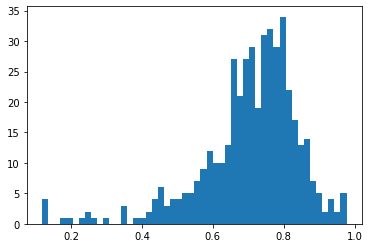

In [18]:
_ = plt.hist((gen_imgs[:,:].flatten()+1)/2, bins=50)

[ 0.31970263  0.515989    0.49027514  0.49008897  0.10881753  0.10962998
  0.51369274  0.16746858  0.2445306   0.48302472  0.4018471   0.22692433
  0.13763197  0.15715739  0.19329031  0.52220714  0.5808567   0.63509583
  0.4738487   0.72945625  0.3703121   0.4531869   0.30219564  0.4078546
  0.6063433   0.4267282   0.5274423  -0.0567499   0.69468045  0.67868
  0.3730603   0.56568056  0.30974555  0.27541545  0.14954782  0.1525824
  0.00756689 -0.74824536  0.9546089  -0.16062172  0.6375904  -0.61645067
 -0.4018499   0.55653566  0.08622433]
[ 0.0076 -0.7482  0.9546 -0.1606  0.6376 -0.6165 -0.4018  0.5565  0.0862]


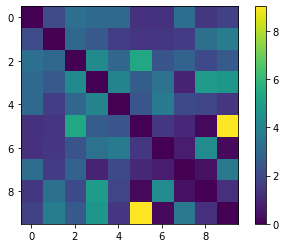

In [19]:
data_new = np.array(gen_imgs[1])
print(data_new)

atomidentities = data_new[-9:]
print(np.around(atomidentities, 4))
#data_new = data_new[:-9]*maximum
#new_sample =squareform(pca.inverse_transform([data_new])[0])
#new_sample = scaler.inverse_transform([data_new])[0]
new_sample = squareform(10**data_new)
#new_sample = new_sample-np.min(new_sample)

plt.imshow(new_sample)
plt.colorbar()

In [20]:
def to_M_matrix(D):
    D1j = np.tile(D[0, :], len(D)).reshape(D.shape)
    Di1 = D1j.T
    return .5 * (-D + D1j + Di1)

def setPositions(mol_in, coords):
    conformer = mol_in.GetConformer(0)
    for i in range(mol_in.GetNumAtoms()):
        x,y,z = coords[i]
        conformer.SetAtomPosition(i,Point3D(x,y,z))
    return mol_in

D = new_sample**2
M = to_M_matrix(D)
S, U = np.linalg.eigh(M)

coord = np.matmul(U, np.diag(np.sqrt(np.abs(S))))
X = coord[:, -3:]


In [21]:
def get_proto_mol(atomicNumList):
    mol = Chem.MolFromSmarts("[#"+str(atomicNumList[0])+"]")
    rwMol = Chem.RWMol(mol)
    for i in range(1,len(atomicNumList)):
        a = Chem.Atom(atomicNumList[i])
        rwMol.AddAtom(a)

    mol = rwMol.GetMol()

    return mol


def xyz2AC(atomicNumList,xyz):
    import numpy as np
    mol = get_proto_mol(atomicNumList)

    conf = Chem.Conformer(mol.GetNumAtoms())
    for i in range(mol.GetNumAtoms()):
        conf.SetAtomPosition(i,(float(xyz[i][0]),float(xyz[i][1]),float(xyz[i][2])))
    mol.AddConformer(conf)

    dMat = Chem.Get3DDistanceMatrix(mol)
    pt = Chem.GetPeriodicTable()

    num_atoms = len(atomicNumList)
    AC = np.zeros((num_atoms,num_atoms)).astype(int)

    for i in range(num_atoms):
        a_i = mol.GetAtomWithIdx(i)
        Rcov_i = pt.GetRcovalent(a_i.GetAtomicNum())*1.30
        for j in range(i+1,num_atoms):
            a_j = mol.GetAtomWithIdx(j)
            Rcov_j = pt.GetRcovalent(a_j.GetAtomicNum())*1.30
            if dMat[i,j] <= Rcov_i + Rcov_j:
                AC[i,j] = 1
                AC[j,i] = 1

    return AC,mol


In [25]:
atomicNumList = []
for i in atomidentities:
    if i<0.5:
        atomicNumList.append(6)
    else:
        atomicNumList.append(8)
#atomicNumList= [6]*9


am, mol =xyz2AC(atomicNumList,X)

In [26]:
eMol = Chem.EditableMol(mol)

bonds = np.triu(am)
for j, k in zip(np.where(bonds)[0], np.where(bonds)[1]):
    print(j,k)
    try:
        eMol.AddBond(int(j),int(k))
    except:
        None

0 6
1 3
1 6
2 4


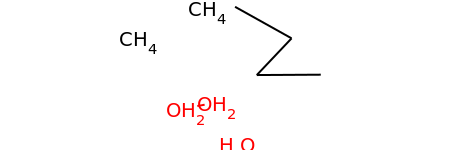

In [27]:
mol = eMol.GetMol()

Chem.rdmolfiles.MolToPDBFile(mol, 'tempmol.pdb', flavor=0)
mol

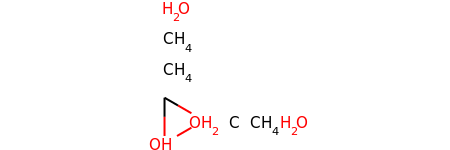

In [665]:
mol.Compute2DCoords()
mol